In [33]:
import requests
import time
from datetime import datetime, timedelta
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import lru_cache
import json
import bs4
import re
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
API_KEY = "fh5hj47dynk4nvx4s9ewufj4"
BASE = "https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/views/istca"
CAT = "https://api.penguinrandomhouse.com/resources/v2/domains/PRH.US/categories/"
TITLE_CAT = "https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/"
session = requests.Session()

In [34]:
BISAC = pd.read_json("bisac_prefixes.json", typ="series").reset_index()
BISAC.columns = ["prefix", "category"]
BISAC

prefix                     category
0     ANT      Antiques & Collectibles
1     ARC                 Architecture
2     BIB                       Bibles
3     BIO    Biography & Autobiography
4     BOD          Body, Mind & Spirit
5     BUS         Business & Economics
6     CGN      Comics & Graphic Novels
7     COM                    Computers
8     CKB                      Cooking
9     CRA             Crafts & Hobbies
10    DES                       Design
11    DRA                        Drama
12    EDU                    Education
13    FAM       Family & Relationships
14    FIC                      Fiction
15    GAM           Games & Activities
16    GAR                    Gardening
17    HEA             Health & Fitness
18    HIS                      History
19    HOM                 House & Home
20    HUM                        Humor
21    JNF          Juvenile Nonfiction
22    JUV             Juvenile Fiction
23    LAN  Language Arts & Disciplines
24    LAW                          Law
25    LCO         Literary Collections
26    LIT           Literary Criticism
27    MAT                  Mathematics
28    MED                      Medical
29    MUS                        Music
30    NAT                       Nature
31    PER              Performing Arts
32    PET                         Pets
33    PHI                   Philosophy
34    PHO                  Photography
35    POE                       Poetry
36    POL            Political Science
37    PSY                   Psychology
38    REF                    Reference
39    REL                     Religion
40    SCI                      Science
41    SEL                    Self-Help
42    SOC               Social Science
43    SPO          Sports & Recreation
44    STU                   Study Aids
45    TEC     Technology & Engineering
46    TRA               Transportation
47    TRU                   True Crime
48    TRV                       Travel
49    YAF          Young Adult Fiction
50    YAN       Young Adult Nonfiction

In [35]:
with open('fiction_BISAC.json', 'r') as f:
    fiction_bisac_codes = json.load(f)
fiction_bisac_codes = fiction_bisac_codes.get('data')
fiction_bisac_codes
f_cat_map = {
    c["catId"]: c["menuText"]
    # c["catId"]: {
    #     "BISAC": c["catUri"],
    #     "Description": c["menuText"]
        for c in fiction_bisac_codes["categories"]
}
f_cat_map

{3000001525: 'Fiction',
 3000001526: 'Absurdist',
 3000001527: 'Action & Adventure',
 3000001528: 'Adaptations & Pastiche',
 3000001529: 'African American & Black',
 3000001530: 'Christian',
 3000001531: 'Erotica',
 3000001532: 'Historical',
 3000001533: 'Mystery & Detective',
 3000001534: 'Urban & Street Lit',
 3000001535: 'Women',
 3000001536: 'Alternative History',
 3000001537: 'Amish & Mennonite',
 3000001538: 'Animals',
 3000001539: 'Anthologies (multiple authors)',
 3000001540: 'Asian American & Pacific Islander',
 3000001541: 'Biographical & Autofiction',
 3000001542: 'Books, Bookstores & Libraries',
 3000001543: 'Buddhist',
 3000001544: 'Christian',
 3000001545: 'Biblical',
 3000001546: 'Classic & Allegory',
 3000001547: 'Collections & Anthologies',
 3000001548: 'Contemporary',
 3000001549: 'Fantasy',
 3000001550: 'Futuristic',
 3000001551: 'Historical',
 3000001552: 'Romance',
 3000001553: 'Historical',
 3000001555: 'Suspense',
 3000001556: 'Western',
 3000001558: 'City Life',

In [86]:
len(f_cat_map)

369

In [91]:
f_cat_id = {}
for key, value in f_cat_map.items():
    if value not in f_cat_id.values():
        f_cat_id[key] = value

f_cat_id

{3000001525: 'Fiction',
 3000001526: 'Absurdist',
 3000001527: 'Action & Adventure',
 3000001528: 'Adaptations & Pastiche',
 3000001529: 'African American & Black',
 3000001530: 'Christian',
 3000001531: 'Erotica',
 3000001532: 'Historical',
 3000001533: 'Mystery & Detective',
 3000001534: 'Urban & Street Lit',
 3000001535: 'Women',
 3000001536: 'Alternative History',
 3000001537: 'Amish & Mennonite',
 3000001538: 'Animals',
 3000001539: 'Anthologies (multiple authors)',
 3000001540: 'Asian American & Pacific Islander',
 3000001541: 'Biographical & Autofiction',
 3000001542: 'Books, Bookstores & Libraries',
 3000001543: 'Buddhist',
 3000001545: 'Biblical',
 3000001546: 'Classic & Allegory',
 3000001547: 'Collections & Anthologies',
 3000001548: 'Contemporary',
 3000001549: 'Fantasy',
 3000001550: 'Futuristic',
 3000001552: 'Romance',
 3000001555: 'Suspense',
 3000001556: 'Western',
 3000001558: 'City Life',
 3000001559: 'Classics',
 3000001560: 'Coming Of Age',
 3000001561: 'Crime',
 3

In [92]:
len(f_cat_id)

257

In [93]:
def fetch_istca_multi(catIds, rows=20):
    results = []

    for catId in catIds:

        params = {
            "formatFamily": "Paperback",
            "catId": catId,
            "showFlapCopy": "true",
            "showPublishedBooks": "true",
            "start": 0,
            "rows": rows,
            "api_key": API_KEY,
        }

        r = session.get(BASE, params=params, timeout=20)

        print("\n---")
        print("CATID:", catId)
        print("STATUS:", r.status_code)
        print("URL:", r.url)
        print("RAW:", r.text[:200])

        r.raise_for_status()
        results.append(r.json())

    return results

In [ ]:
fetch_istca_multi([3000001525, 3000001526, 3000001527], rows=10)


---
CATID: 3000001525
STATUS: 200
URL: https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/views/istca?formatFamily=Paperback&catId=3000001525&showFlapCopy=true&showPublishedBooks=true&start=0&rows=10&api_key=fh5hj47dynk4nvx4s9ewufj4
RAW: {"status":"ok","recordCount":33893,"startTimestamp":"2025-11-22T08:01:39Z","endTimestamp":"2025-11-22T08:01:55Z","timeTaken":15283,"data":[{"isbn":9780140014457,"isbnHyphenated":"978-0-14-001445-7","w

---
CATID: 3000001526
STATUS: 200
URL: https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/views/istca?formatFamily=Paperback&catId=3000001526&showFlapCopy=true&showPublishedBooks=true&start=0&rows=10&api_key=fh5hj47dynk4nvx4s9ewufj4
RAW: {"status":"ok","recordCount":93,"startTimestamp":"2025-11-22T08:01:55Z","endTimestamp":"2025-11-22T08:01:55Z","timeTaken":56,"data":[{"isbn":9780140154078,"isbnHyphenated":"978-0-14-015407-8","workId"

---
CATID: 3000001527
STATUS: 200
URL: https://api.penguinrandomhouse

[{'status': 'ok',
  'recordCount': 33893,
  'startTimestamp': '2025-11-22T08:01:39Z',
  'endTimestamp': '2025-11-22T08:01:55Z',
  'timeTaken': 15283,
  'data': [{'isbn': 9780140014457,
    'isbnHyphenated': '978-0-14-001445-7',
    'workId': 323693,
    'title': 'Under the Net',
    'author': 'Iris Murdoch',
    'coverUrl': 'https://images.penguinrandomhouse.com/cover/9780140014457',
    'format': {'code': 'TR', 'description': 'Trade Paperback'},
    'subformat': None,
    'binding': None,
    'editionTarget': {'code': None, 'description': None},
    'trim': '5-1/16 x 7-3/4',
    'edition': '0',
    'onSaleDate': '1977-10-27',
    'exportOnSaleDate': None,
    'price': 16.0,
    'exportPrice': None,
    'globalDivision': None,
    'publishingDivision': 'Penguin Adult HC/TR',
    'imprint': 'Penguin Books',
    'publishingStatus': 'IP',
    'series': None,
    'language': 'E',
    'seq': None,
    'titleBlock': None,
    'description': "<b>Iris Murdoch's debut&mdash;a comic novel about 

In [85]:
corpus_cats = [3000001533, 3000001667, 3000001731, 3000001771, 3000001784, 3000001824]

In [ ]:
fetch = fetch_istca_multi(corpus_cats)


---
CATID: 3000001525
STATUS: 200
URL: https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/views/istca?formatFamily=Paperback&catId=3000001525&showFlapCopy=true&showPublishedBooks=true&start=0&rows=100&api_key=fh5hj47dynk4nvx4s9ewufj4
RAW: {"status":"ok","recordCount":33893,"startTimestamp":"2025-11-22T08:01:57Z","endTimestamp":"2025-11-22T08:02:08Z","timeTaken":11171,"data":[{"isbn":9780140014457,"isbnHyphenated":"978-0-14-001445-7","w

---
CATID: 3000001526
STATUS: 200
URL: https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/views/istca?formatFamily=Paperback&catId=3000001526&showFlapCopy=true&showPublishedBooks=true&start=0&rows=100&api_key=fh5hj47dynk4nvx4s9ewufj4
RAW: {"status":"ok","recordCount":93,"startTimestamp":"2025-11-22T08:02:09Z","endTimestamp":"2025-11-22T08:02:09Z","timeTaken":178,"data":[{"isbn":9780140154078,"isbnHyphenated":"978-0-14-015407-8","workId

---
CATID: 3000001527
STATUS: 200
URL: https://api.penguinrandomhou

In [46]:
# corpus = pd.DataFrame(fetch[0]['data'])
for catid in fetch:
    df = pd.DataFrame(catid['data'])
    try:
        corpus = pd.concat([corpus, df], ignore_index=True)
    except NameError:
        corpus = df

corpus = corpus.drop(columns=['isbnHyphenated', 'workId', 'coverUrl',
       'format', 'subformat', 'binding', 'editionTarget', 'trim', 'edition',
       'onSaleDate', 'exportOnSaleDate', 'price', 'exportPrice',
       'globalDivision', 'publishingDivision', 'imprint', 'publishingStatus',
       'series', 'language', 'seq', 'titleBlock', 'authors'])
# corpus.set_index('isbn', inplace=True)
corpus

isbn                               title          author  \
0    9780140014457                       Under the Net    Iris Murdoch   
1    9780140014747                      The Sandcastle    Iris Murdoch   
2    9780140020038                      A Severed Head    Iris Murdoch   
3    9780140024760                         The Unicorn    Iris Murdoch   
4    9780140030341               The Nice and the Good    Iris Murdoch   
..             ...                                 ...             ...   
288  9780307475558        The Adventures of Tom Sawyer      Mark Twain   
289  9780307475565  The Adventures of Huckleberry Finn      Mark Twain   
290  9780307717108                  The Informationist  Taylor Stevens   
291  9780307743176                 Jamrach's Menagerie     Carol Birch   
292  9780307743626                          Angelmaker   Nick Harkaway   

                                           description  
0    <b>Iris Murdoch's debut&mdash;a comic novel ab...  
1    <b>A sparklingly profound novel about the conf...  
2    <b>A novel about the frightfulness and ruthles...  
3    <b>A brilliant mythical drama about well-meani...  
4    From the Booker Prize-winning author of <i>The...  
..                                                 ...  
288  Mark Twain was one of the nineteenth century's...  
289  <b>Long cherished by readers of all ages: the ...  
290  <b>Governments pay her.</b><br><b>Criminals fe...  
291  <p>Nineteenth-century London comes vividly ali...  
292  <b>A rollicking romp of a spy thriller from th...  

[293 rows x 4 columns]

In [47]:
corpus.loc[:, 'description'] = (
    corpus['description']
        .str.replace(r"<.*?>", "", regex=True)            
        .str.replace(r"&[A-Za-z0-9#]+;", "", regex=True)  
        .str.replace(r"\d+", "", regex=True)              
        .str.strip()
)
corpus = corpus.drop_duplicates(subset=['title'], keep='first')
corpus.reset_index(drop=True, inplace=True)
corpus

isbn                              title  \
0    9780140014457                      Under the Net   
1    9780140014747                     The Sandcastle   
2    9780140020038                     A Severed Head   
3    9780140024760                        The Unicorn   
4    9780140030341              The Nice and the Good   
..             ...                                ...   
277  9780307473820                Invasion of Privacy   
278  9780307474506  The Big Book of Adventure Stories   
279  9780307717108                 The Informationist   
280  9780307743176                Jamrach's Menagerie   
281  9780307743626                         Angelmaker   

                                          author  \
0                                   Iris Murdoch   
1                                   Iris Murdoch   
2                                   Iris Murdoch   
3                                   Iris Murdoch   
4                                   Iris Murdoch   
..                                           ...   
277                            Christopher Reich   
278  Edited with an Introduction by Otto Penzler   
279                               Taylor Stevens   
280                                  Carol Birch   
281                                Nick Harkaway   

                                           description  
0    Iris Murdoch's debuta comic novel about work a...  
1    A sparklingly profound novel about the conflic...  
2    A novel about the frightfulness and ruthlessne...  
3    A brilliant mythical drama about well-meaning ...  
4    From the Booker Prize-winning author of The Se...  
..                                                 ...  
277  While meeting with a confidential informant, M...  
278  A hair-raising collection of adventure stories...  
279  Governments pay her.Criminals fear her.Nobody ...  
280  Nineteenth-century London comes vividly alive ...  
281  A rollicking romp of a spy thriller from the a...  

[282 rows x 4 columns]

In [48]:
corpus.shape

(282, 4)

#### Step 1. Establish corpus

In [49]:
# Focus on descriptions only
working_corpus = corpus['description']
working_corpus

0      Iris Murdoch's debuta comic novel about work a...
1      A sparklingly profound novel about the conflic...
2      A novel about the frightfulness and ruthlessne...
3      A brilliant mythical drama about well-meaning ...
4      From the Booker Prize-winning author of The Se...
                             ...                        
277    While meeting with a confidential informant, M...
278    A hair-raising collection of adventure stories...
279    Governments pay her.Criminals fear her.Nobody ...
280    Nineteenth-century London comes vividly alive ...
281    A rollicking romp of a spy thriller from the a...
Name: description, Length: 282, dtype: object

#### Step 2. Perform TF-IDF on corpus

In [50]:
# TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(working_corpus)

# Get the feature names (words in the vocabulary)
feature_names = vectorizer.get_feature_names_out()

# Convert the sparse matrix to a dense array for easier viewing (for small datasets)
dense_matrix = tfidf_matrix.toarray()

# Create a DataFrame for better readability
tf_idf_df = pd.DataFrame(dense_matrix, columns=feature_names)
tf_idf_df

abandon  abandoned  abandonment  abbess  abc  abducida  abe  abernathy  \
0        0.0   0.000000          0.0     0.0  0.0       0.0  0.0        0.0   
1        0.0   0.000000          0.0     0.0  0.0       0.0  0.0        0.0   
2        0.0   0.000000          0.0     0.0  0.0       0.0  0.0        0.0   
3        0.0   0.000000          0.0     0.0  0.0       0.0  0.0        0.0   
4        0.0   0.000000          0.0     0.0  0.0       0.0  0.0        0.0   
..       ...        ...          ...     ...  ...       ...  ...        ...   
277      0.0   0.000000          0.0     0.0  0.0       0.0  0.0        0.0   
278      0.0   0.000000          0.0     0.0  0.0       0.0  0.0        0.0   
279      0.0   0.000000          0.0     0.0  0.0       0.0  0.0        0.0   
280      0.0   0.000000          0.0     0.0  0.0       0.0  0.0        0.0   
281      0.0   0.083281          0.0     0.0  0.0       0.0  0.0        0.0   

     abeyance  abiding  ...  zoasand  zodiac  zone  zones  zoo  zoos  zoran  \
0         0.0      0.0  ...      0.0     0.0   0.0    0.0  0.0   0.0    0.0   
1         0.0      0.0  ...      0.0     0.0   0.0    0.0  0.0   0.0    0.0   
2         0.0      0.0  ...      0.0     0.0   0.0    0.0  0.0   0.0    0.0   
3         0.0      0.0  ...      0.0     0.0   0.0    0.0  0.0   0.0    0.0   
4         0.0      0.0  ...      0.0     0.0   0.0    0.0  0.0   0.0    0.0   
..        ...      ...  ...      ...     ...   ...    ...  ...   ...    ...   
277       0.0      0.0  ...      0.0     0.0   0.0    0.0  0.0   0.0    0.0   
278       0.0      0.0  ...      0.0     0.0   0.0    0.0  0.0   0.0    0.0   
279       0.0      0.0  ...      0.0     0.0   0.0    0.0  0.0   0.0    0.0   
280       0.0      0.0  ...      0.0     0.0   0.0    0.0  0.0   0.0    0.0   
281       0.0      0.0  ...      0.0     0.0   0.0    0.0  0.0   0.0    0.0   

        zorro  zulu  zuzzo  
0    0.000000   0.0    0.0  
1    0.000000   0.0    0.0  
2    0.000000   0.0    0.0  
3    0.000000   0.0    0.0  
4    0.000000   0.0    0.0  
..        ...   ...    ...  
277  0.000000   0.0    0.0  
278  0.100872   0.0    0.0  
279  0.000000   0.0    0.0  
280  0.000000   0.0    0.0  
281  0.000000   0.0    0.0  

[282 rows x 9412 columns]

#### Step 3. Perform NMF

In [51]:
# Range of topic numbers to test
topic_range = [5, 10, 15, 20, 30, 40, 50]

errors = {}

print("Testing different numbers of topics...\n")

for k in topic_range:
    model = NMF(
        n_components=k,
        init="nndsvd",
        random_state=1,
        max_iter=400
    )

    model.fit(tf_idf_df)
    err = model.reconstruction_err_
    errors[k] = err

    print(f"k = {k:2d}, reconstruction error = {err:.4f}")

# Best k = minimum reconstruction error
best_k = min(errors, key=errors.get)

print("\nOptimal number of topics:", best_k)

Testing different numbers of topics...

k =  5, reconstruction error = 16.1752
k = 10, reconstruction error = 15.9116


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(


k = 15, reconstruction error = 15.6960


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(


k = 20, reconstruction error = 15.4998


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(


k = 30, reconstruction error = 15.1181


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(


k = 40, reconstruction error = 14.7545
k = 50, reconstruction error = 14.3928

Optimal number of topics: 50


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(


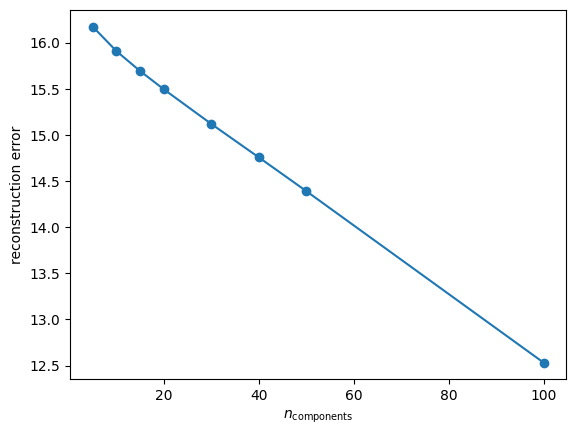

In [52]:
n_components = [5, 10, 15, 20, 30, 40, 50, 100]
errors = []
for n_component in n_components:
    nmf_ = NMF(n_component, max_iter=10000)
    nmf_.fit(tf_idf_df)
    errors.append(nmf_.reconstruction_err_)
plt.plot(n_components, errors, '-o')
plt.xlabel(r'$n_\text{components}$')
plt.ylabel('reconstruction error');

In [53]:
# Instantiate the NMF model & specify the number of topics
# Set random_state for reproducibility
n_topics = 10
nmf_model = NMF(n_components=n_topics, random_state=1).set_output(transform="pandas")

# Fit the NMF model to the TF-IDF matrix
# Note that the 'H' matrix (topic-term distribution) is in nmf_model.components_
# Note that the 'W' matrix (document-topic distribution) can be obtained with model.transform(tfidf_matrix)
nmf_model.fit(tf_idf_df)

# Function to print the top words for each topic (from search results)
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(nmf_model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

#### Find Optimal Number of Topics

In [54]:
# topic_no =

In [17]:
# Print the top words per topic from search results
# print_top_words(nmf_model, feature_names, topic_no) # uncomment when using topic_no 
print_top_words(nmf_model, feature_names, 10)

Topic #0:
penguin classic classics notes readers authoritative publisher english scholars bookshelf
Topic #1:
new debut jonny outrageously love seep trina deeba abernathy chance
Topic #2:
la en el una que su por es los novela
Topic #3:
albany cycle ironweed mid legs billy quinns novels irish bones
Topic #4:
sharpe napoleon battle richard enemy french honor wellington napoleonic british
Topic #5:
morgan survivalist home carter camp grid collapse series protect nations
Topic #6:
stories short collection writersa masterpieces irresistible eighty williams surprising fiction
Topic #7:
ravicka gladman renee city architecture ravickians ravickian patova kafka crosses
Topic #8:
glass trilogy detective room locked post ghosts paul novels york
Topic #9:
book moon best times novel york hjorth new post read
Topic #10:
kerouacs road jack meaning freedom gerard changed seekers generation quest
Topic #11:
jonathan rules emma ransom wife christopher international betrayal swiss borders
Topic #12:
coet

In [55]:
# Get the document-topic distribution
document_topic = nmf_model.transform(tf_idf_df)
document_topic

nmf0      nmf1      nmf2      nmf3      nmf4      nmf5      nmf6  \
0    0.000000  0.071327  0.000928  0.008901  0.000000  0.000000  0.000000   
1    0.000000  0.093347  0.000000  0.000000  0.018078  0.007607  0.000000   
2    0.000000  0.075169  0.000393  0.000000  0.009422  0.000000  0.000000   
3    0.000000  0.101820  0.000000  0.000000  0.000000  0.000000  0.000000   
4    0.007347  0.075775  0.000000  0.000000  0.004184  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
277  0.000000  0.081475  0.000000  0.000000  0.003321  0.037256  0.000000   
278  0.013204  0.000000  0.000000  0.000373  0.007864  0.003953  0.260534   
279  0.000575  0.073486  0.000000  0.000000  0.008526  0.043318  0.005406   
280  0.012226  0.063349  0.000000  0.009355  0.000000  0.000000  0.001729   
281  0.001002  0.083336  0.007422  0.006972  0.008171  0.006598  0.010284   

         nmf7      nmf8      nmf9  
0    0.004530  0.000000  0.007439  
1    0.001310  0.000000  0.040320  
2    0.000000  0.000000  0.093720  
3    0.000000  0.000000  0.000000  
4    0.000000  0.003329  0.000000  
..        ...       ...       ...  
277  0.000000  0.000000  0.006694  
278  0.000000  0.000000  0.026253  
279  0.003241  0.033354  0.043949  
280  0.000000  0.000000  0.039410  
281  0.000000  0.000000  0.037768  

[282 rows x 10 columns]

#### Step 4. Create a query function

In [58]:
# Get top words per topic from search results
n_top_words = 10
topic_dict = {}
for topic_idx, topic in enumerate(nmf_model.components_):
        topic_dict[topic_idx] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
topic_dict

{0: ['penguin',
  'classic',
  'classics',
  'english',
  'notes',
  'readers',
  'authoritative',
  'publisher',
  'introductions',
  'bookshelf'],
 1: ['novel',
  'life',
  'world',
  'story',
  'man',
  'young',
  'love',
  'woman',
  'war',
  'work'],
 2: ['la', 'en', 'el', 'una', 'que', 'su', 'por', 'es', 'los', 'novela'],
 3: ['albany',
  'cycle',
  'ironweed',
  'mid',
  'legs',
  'billy',
  'quinns',
  'novels',
  'irish',
  'bones'],
 4: ['sharpe',
  'napoleon',
  'battle',
  'richard',
  'enemy',
  'french',
  'wellington',
  'honor',
  'napoleonic',
  'british'],
 5: ['morgan',
  'survivalist',
  'home',
  'carter',
  'camp',
  'collapse',
  'grid',
  'series',
  'protect',
  'family'],
 6: ['stories',
  'collection',
  'short',
  'fiction',
  'complete',
  'masterpieces',
  'writersa',
  'irresistible',
  'works',
  'including'],
 7: ['ravicka',
  'gladman',
  'city',
  'renee',
  'architecture',
  'ravickians',
  'ravickian',
  'patova',
  'kafka',
  'crosses'],
 8: ['book

In [70]:
# Identify topics that contain the words in the query
query = 'absurdist fiction'

search_topic_list = []
for word in query.lower().split():
    counter = 0
    for topic in topic_dict.values():
        if word in topic:
            search_topic_list.append(counter)
        counter += 1

search_topic_list

[6]

In [71]:
# Create a dataframe that contains all relevant topics
working_df = pd.DataFrame(document_topic.iloc[:, search_topic_list])
# working_df.set_index(corpus['isbn'], inplace=True)

# Get the total row score for each isbn
working_df['score'] = working_df.iloc[:, 0:].sum(axis=1)
working_df

result = working_df.sort_values(axis=0, by='score', ascending=False).head(10)
result = result[result['score'] > 0]
result

nmf6     score
130  0.360529  0.360529
152  0.332139  0.332139
39   0.325316  0.325316
278  0.260534  0.260534
126  0.244891  0.244891
42   0.234884  0.234884
178  0.213420  0.213420
74   0.197668  0.197668
95   0.179994  0.179994
87   0.176433  0.176433

#### Cosine Similarity Query

In [72]:
from sklearn.metrics.pairwise import cosine_similarity

def nmf_query_search(query, tfidf, nmf, W, top_k=10):

    # 1. Transform query using the SAME TF-IDF model
    q_tfidf = tfidf.transform([query])

    # 2. Project query into SAME NMF topic space
    q_vec = nmf.transform(q_tfidf)

    # 3. Cosine similarity
    sims = cosine_similarity(q_vec, W).ravel()

    # 4. Sort
    top_idx = sims.argsort()[::-1][:top_k]

    return top_idx, sims[top_idx]


In [79]:
idx, scores =  nmf_query_search(query='absurdist fiction', tfidf=vectorizer, nmf=nmf_model, W=document_topic, top_k=10)
# idx, scores
q_result = corpus.iloc[idx][['isbn', 'title', 'description']]
q_result

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but NMF was fitted with feature names
  warnings.warn(


isbn                                title  \
168  9781685890841    Walter Benjamin Stares at the Sea   
140  9781593764166                The Great Frustration   
45   9780140088793                     Wedding Readings   
66   9780140115765                                  Utz   
99   9780140150445                  The Portable Milton   
171  9781788739887                     Terminal Boredom   
192  9780140157376        Haroun and the Sea of Stories   
72   9780140127836                Spells of Enchantment   
184  9781984897589          Good Citizens Need Not Fear   
71   9780140124453  The Penguin Book of Vampire Stories   

                                           description  
168  A  book that belongs on the same shelf as Ital...  
140  Frieds stories are laugh-out-loud hilarious an...  
45   This rich collection of writings on the nature...  
66   An elegant novel set in Prague about the possi...  
99   The Portable Milton is an authoritative grand ...  
171  Named a Most Anticipated Book of  by Thrillist...  
192  A captivating fantasy novel for readers of all...  
72   Spells of Enchantment brings together the best...  
184  "These immersive linked stories grapple with U...  
71   The terrifying and definitive collection of Va...

In [80]:
def get_title_categories(isbn):
    params = {
        "api_key": API_KEY,
    }
    cat_url = f"{TITLE_CAT}{isbn}/categories"
    r = session.get(cat_url, params=params, timeout=20)
    print(r)
    print("STATUS:", r.status_code)
    print("URL:", r.url)
    print("RAW:", r.text[:250])

    r.raise_for_status()
    return r.json()

In [81]:
isbn = 9780140014457
print(f"{TITLE_CAT}{isbn}/categories")
print("https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/9780140014457/categories?api_key=fh5hj47dynk4nvx4s9ewufj4")

https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/9780140014457/categories
https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/9780140014457/categories?api_key=fh5hj47dynk4nvx4s9ewufj4


In [82]:
get_title_categories(isbn)

<Response [200]>
STATUS: 200
URL: https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/9780140014457/categories?api_key=fh5hj47dynk4nvx4s9ewufj4
RAW: {"status":"ok","recordCount":46,"startTimestamp":"2025-11-22T09:00:23Z","endTimestamp":"2025-11-22T09:00:23Z","timeTaken":20,"data":{"categories":[{"catId":2000000057,"description":"Fiction","catSetId":"CN","catUri":"/fiction","menuText":"Fiction","h


{'status': 'ok',
 'recordCount': 46,
 'startTimestamp': '2025-11-22T09:00:23Z',
 'endTimestamp': '2025-11-22T09:00:23Z',
 'timeTaken': 20,
 'data': {'categories': [{'catId': 2000000057,
    'description': 'Fiction',
    'catSetId': 'CN',
    'catUri': '/fiction',
    'menuText': 'Fiction',
    'hasChildren': True,
    'seq': 0,
    'weight': 0,
    '_embeds': None,
    '_links': [{'rel': 'self',
      'href': 'https://api.penguinrandomhouse.com/title/client/Public/domains/PRH.US/categories/2000000057?api_key=fh5hj47dynk4nvx4s9ewufj4',
      'method': 'GET',
      'parameters': None},
     {'rel': 'child',
      'href': 'https://api.penguinrandomhouse.com/title/client/Public/domains/PRH.US/categories/2000000057/children?api_key=fh5hj47dynk4nvx4s9ewufj4',
      'method': 'GET',
      'parameters': None},
     {'rel': 'up',
      'href': 'https://api.penguinrandomhouse.com/title/client/Public/domains/PRH.US/categories/2000000057/parent?api_key=fh5hj47dynk4nvx4s9ewufj4',
      'method': 'G

In [83]:
def build_catid_confusion_matrix(q_result, target_catid):
    """
    q_result: DataFrame containing ISBNs in column 'isbn'
    target_catid: int, the catId to evaluate
    
    Returns: DataFrame confusion matrix
    """
    isbns = q_result['isbn'].tolist()
    
    data = []

    for isbn in isbns:
        cats_json = get_title_categories(isbn)

        # default = 0 (category not found)
        has_cat = 0

        if cats_json and "categories" in cats_json:
            cat_ids = [c.get("catId") for c in cats_json["categories"]]
            if target_catid in cat_ids:
                has_cat = 1

        data.append({"isbn": isbn, "has_cat": has_cat})

    df = pd.DataFrame(data)

    # confusion vs the search result rank (1=selected, 0=not)
    df = df.merge(q_result[['isbn']].assign(predicted=1), on="isbn", how="left")

    df["predicted"] = df["predicted"].fillna(0).astype(int)

    # build confusion matrix
    confusion = pd.crosstab(df["has_cat"], df["predicted"], 
                            rownames=["Actual"], colnames=["Predicted"])
    
    return confusion

In [84]:
build_catid_confusion_matrix(q_result, 3000001526)

<Response [200]>
STATUS: 200
URL: https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/9781685890841/categories?api_key=fh5hj47dynk4nvx4s9ewufj4
RAW: {"status":"ok","recordCount":27,"startTimestamp":"2025-11-22T09:45:00Z","endTimestamp":"2025-11-22T09:45:00Z","timeTaken":9,"data":{"categories":[{"catId":2000000057,"description":"Fiction","catSetId":"CN","catUri":"/fiction","menuText":"Fiction","ha
<Response [200]>
STATUS: 200
URL: https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/9781593764166/categories?api_key=fh5hj47dynk4nvx4s9ewufj4
RAW: {"status":"ok","recordCount":16,"startTimestamp":"2025-11-22T09:45:01Z","endTimestamp":"2025-11-22T09:45:01Z","timeTaken":12,"data":{"categories":[{"catId":2000000057,"description":"Fiction","catSetId":"CN","catUri":"/fiction","menuText":"Fiction","h
<Response [200]>
STATUS: 200
URL: https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/9780140088793/categories?api_key=fh5hj47dy

Predicted   1
Actual       
0          10